# Install, Paths and Parameters

In [1]:
import os
from pathlib import Path
import getpass
import numpy as np
import time
import torch
from torch import nn
from tqdm import tqdm
import random
import sys

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.data import create_loader
from src.model.eval import validate_network

# Custom imports
import torchattacks
from torchattacks import *
import torch.optim as optim
from torchvision import transforms as pth_transforms

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')

DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')

ORI_PATH = Path(DATA_PATH, 'ori_data/validation')
ORI_LABEL_PATH = Path(ORI_PATH,'correct_labels.txt')
ORI_IMAGES_PATH = Path(ORI_PATH,'images')

In [17]:
INDEX_SUBSET = get_random_indexes(n_samples=3000)

BATCH_SIZE = 30

DEVICE = 'cuda'

In [18]:
len(INDEX_SUBSET)

3000

In [19]:
#!python ../setup/collect_env.py

# Evaluate DINO ViT

## Load model

In [20]:
model, linear_classifier = get_dino(model_name='vit_base', patch_size=16, n_last_blocks=1, avgpool_patchtokens=True, device=DEVICE)

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_base built.
Embed dim 1536
We load the reference pretrained linear weights from dino_vitbase16_pretrain/dino_vitbase16_linearweights.pth.


## Load data

In [21]:
org_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, INDEX_SUBSET, None, BATCH_SIZE, remove_normalization=True)
len(org_loader.dataset)

3000

## Wrap model

In [22]:
model_wrap = ViTWrapper(model, linear_classifier, DEVICE, n_last_blocks=1, avgpool_patchtokens=True)
model_wrap= model_wrap.to(DEVICE)

## Attack model

In [25]:
attacks = [
    #FGSM(model_wrap, eps=0.003),
    #FGSM(model_wrap, eps=0.03),
    #FGSM(model_wrap, eps=0.06),
    PGD(model_wrap, eps=0.003, alpha=0.003, steps=20),
    #PGD(model_wrap, eps=0.03, alpha=0.003, steps=20),
    #PGD(model_wrap, eps=0.06, alpha=0.003, steps=20),
    CW(model_wrap, c=10, lr=0.003, steps=30),
    #CW(model_wrap, c=50, lr=0.003, steps=30),
]

#### Compute clean accuracy

In [9]:
clean_correct = 0
total = len(org_loader.dataset)
start = time.time()

with torch.no_grad():
    for images, labels, _ in tqdm(org_loader):

        cuda_images = images.to(DEVICE)
        clean_outputs = model_wrap(cuda_images)
        labels = labels.to(DEVICE)

        _, pre_clean = torch.max(clean_outputs.data, 1)

        clean_correct += (pre_clean == labels).sum()

print('Total elapsed time (sec): %.2f' % (time.time() - start))
print('Clean accuracy: %.2f %%' % (100 * float(clean_correct) / total))

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]

Total elapsed time (sec): 52.37
Clean accuracy: 78.87 %


In [23]:
torch.cuda.empty_cache()

In [26]:
total = len(org_loader.dataset)

for atk in attacks:
    
    print("-"*70)
    print(atk)
    
    correct = 0
    clean_correct = 0
    start = time.time()
    
    for images, labels, _ in tqdm(org_loader):
        
        labels = labels.to(DEVICE)
        adv_images = atk(images, labels)
        
        with torch.no_grad():
            outputs = model_wrap(adv_images)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()

        del images
        del labels
        del adv_images
        torch.cuda.empty_cache()

    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Accuracy against attack: %.2f %%' % (100 * float(correct) / total))

  0%|          | 0/100 [00:00<?, ?it/s]

----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.003, alpha=0.003, steps=20, random_start=True, attack_mode=default, return_type=float)


  0%|          | 0/100 [00:00<?, ?it/s]

Total elapsed time (sec): 750.55
Accuracy against attack: 19.77 %
----------------------------------------------------------------------
CW(model_name=ViTWrapper, device=cuda:0, c=10, kappa=0, steps=30, lr=0.003, attack_mode=default, return_type=float)


100%|██████████| 100/100 [08:15<00:00,  4.95s/it]

Total elapsed time (sec): 495.25
Accuracy against attack: 0.43 %


# Original ViT

In [27]:
del model, linear_classifier, model_wrap
torch.cuda.empty_cache()

## Load model

In [28]:
from PIL import Image
import torch
from torchvision import transforms

# Load ViT
from pytorch_pretrained_vit import ViT
vit_model = ViT('B_16_imagenet1k', pretrained=True).to(DEVICE)
vit_model.eval()

# Define custom transform for this model
transform = transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

img = transform(Image.open('/cluster/home/jrando/AADefDINO/data/ori_data/validation/images/ILSVRC2012_val_00000064.JPEG')).unsqueeze(0).to(DEVICE)
print(img.shape) # torch.Size([1, 3, 384, 384])

# Classify
with torch.no_grad():
    outputs = vit_model(img)
print(outputs.shape)  # (1, 1000)

Loaded pretrained weights.
torch.Size([1, 3, 384, 384])
torch.Size([1, 1000])


In [29]:
outputs.argmax()

tensor(46, device='cuda:0')

## Load data

In [30]:
BATCH_SIZE = 10
vit_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, INDEX_SUBSET, None, BATCH_SIZE, is_adv_training=True, transform=transform)
len(vit_loader.dataset)

3000

## Attack model

#### Compute clean accuracy

In [23]:
clean_correct = 0
total = len(vit_loader.dataset)
start = time.time()

with torch.no_grad():
    for images, labels, _ in tqdm(vit_loader):

        cuda_images = images.to(DEVICE)
        clean_outputs = vit_model(cuda_images)
        labels = labels.to(DEVICE)

        _, pre_clean = torch.max(clean_outputs.data, 1)

        clean_correct += (pre_clean == labels).sum()

print('Total elapsed time (sec): %.2f' % (time.time() - start))
print('Clean accuracy: %.2f %%' % (100 * float(clean_correct) / total))

100%|██████████| 300/300 [01:23<00:00,  3.61it/s]

Total elapsed time (sec): 83.14
Clean accuracy: 83.47 %


In [31]:
attacks_vit = [
    #FGSM(vit_model, eps=0.003),
    #FGSM(vit_model, eps=0.03),
    #FGSM(vit_model, eps=0.06),
    #PGD(vit_model, eps=0.003, alpha=0.003, steps=20),
    #PGD(vit_model, eps=0.03, alpha=0.003, steps=20),
    #PGD(vit_model, eps=0.06, alpha=0.003, steps=20),
    CW(vit_model, c=10, lr=0.003, steps=30),
    #CW(vit_model, c=50, lr=0.003, steps=30),
]

In [32]:
total = len(vit_loader.dataset)

for atk in attacks_vit:
    
    print("-"*70)
    print(atk)
    
    correct = 0
    clean_correct = 0
    start = time.time()
    
    for images, labels, _ in tqdm(vit_loader):
        labels = labels.to(DEVICE)
        adv_images = atk(images, labels)
        
        with torch.no_grad():
            outputs = vit_model(adv_images)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()

        del images
        del labels
        del adv_images
        torch.cuda.empty_cache()

    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Accuracy against attack: %.2f %%' % (100 * float(correct) / total))

  0%|          | 0/300 [00:00<?, ?it/s]

----------------------------------------------------------------------
CW(model_name=ViT, device=cuda:0, c=10, kappa=0, steps=30, lr=0.003, attack_mode=default, return_type=float)


100%|██████████| 300/300 [57:59<00:00, 11.60s/it]

Total elapsed time (sec): 3479.97
Accuracy against attack: 0.07 %


# Visualize images

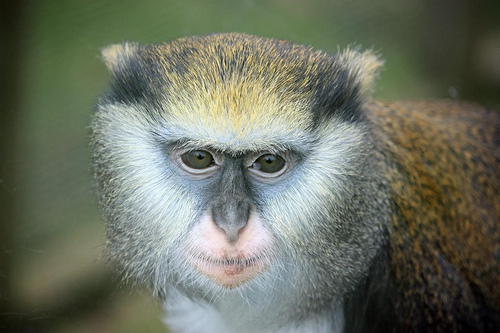

In [3]:
from PIL import Image
Image.open("/cluster/scratch/thobauma/dl_data/ori_data/validation/images/ILSVRC2012_val_00000013.JPEG")

In [43]:
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [38]:
vis_loader = create_loader(ORI_IMAGES_PATH, ORI_LABEL_PATH, [12], None, BATCH_SIZE, is_adv_training=True)
len(vis_loader.dataset)

1

  0%|          | 0/1 [00:00<?, ?it/s]

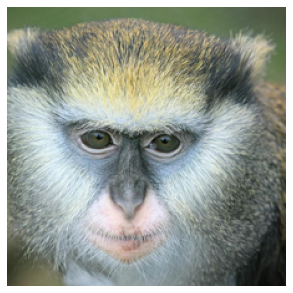

100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


In [44]:
for images, labels, img_names in tqdm(vis_loader):
    imshow(images[0].detach().cpu(), "")

  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.003, attack_mode=default, return_type=float)


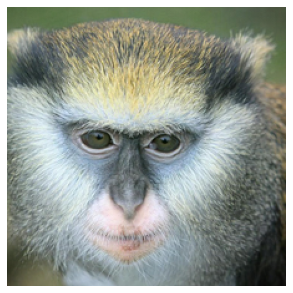

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.03, attack_mode=default, return_type=float)


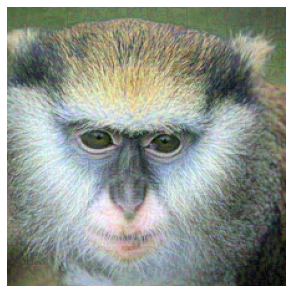

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.06, attack_mode=default, return_type=float)


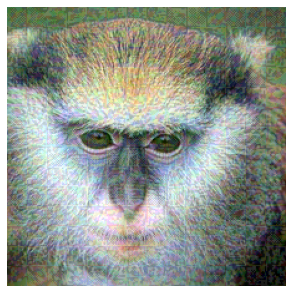

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.003, alpha=0.003, steps=20, random_start=True, attack_mode=default, return_type=float)


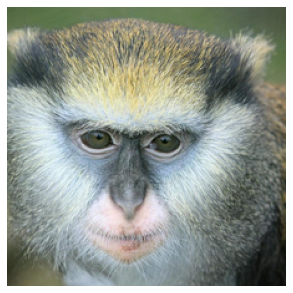

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.03, alpha=0.003, steps=20, random_start=True, attack_mode=default, return_type=float)


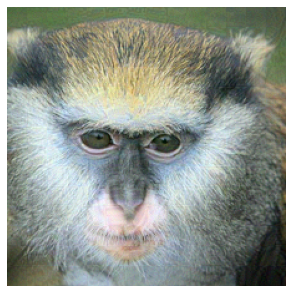

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.06, alpha=0.003, steps=20, random_start=True, attack_mode=default, return_type=float)


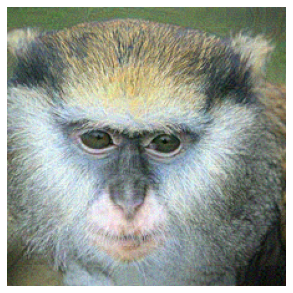

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
CW(model_name=ViTWrapper, device=cuda:0, c=10, kappa=0, steps=30, lr=0.003, attack_mode=default, return_type=float)


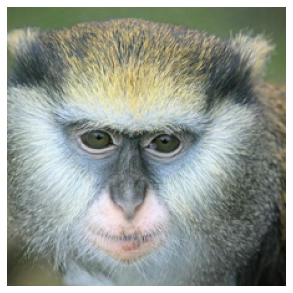

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True
----------------------------------------------------------------------
CW(model_name=ViTWrapper, device=cuda:0, c=50, kappa=0, steps=30, lr=0.003, attack_mode=default, return_type=float)


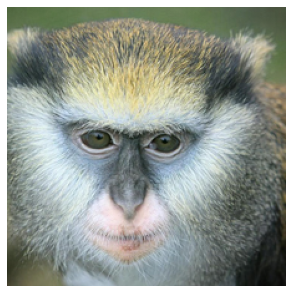

100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

Is adversarial? True


In [45]:
for atk in attacks:
    
    print("-"*70)
    print(atk)

    correct = 0
    clean_correct = 0
    start = time.time()
    
    for images, labels, img_names in tqdm(vis_loader):
        
        labels = labels.to(DEVICE)
        adv_images = atk(images, labels)
        
        with torch.no_grad():
            outputs = model_wrap(adv_images)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()
        
        imshow(adv_images[0].detach().cpu(), "")
        
        print(f"Is adversarial? {correct==0}")